# Time Series Forcasting with Feature Engineering

## Objective

Time series forecasting is a critical task in a variety of domains, ranging from finance to power
management. While traditional statistical methods have been used, recent developments in
machine learning and feature engineering have led to a significant improvement in forecasts.

This project aims to build an end-to-end time series forecasting pipeline,
illustrating how careful feature engineering can greatly improve the predictive capability over a
range of modeling approaches.

## Dataset

The dataset that we have chosen to use in this project is the [Historical Weather Data](https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities) dataset from Kaggle.
This dataset contains daily temperature data for major cities around the world, including the date and the average temperature for each day.

# Installing and Importing Required Libraries

In [55]:
!pip install -r requirements.txt

# Loading the dataset

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

df = pd.read_csv("data/city_temperature.csv", low_memory=False)

# Data Exploration

In [57]:
# View the first rows to get an idea of the data
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


## Understanding the data charecteristics

This is "getting to know the data" and involves analyzing the types of features, their ranges, as well as the distribution of their values.

In [58]:
# Feature types
print("Feature types:")
df.dtypes

Feature types:


Region             object
Country            object
State              object
City               object
Month               int64
Day                 int64
Year                int64
AvgTemperature    float64
dtype: object

In [59]:
# Range of features
print("Range of features:")
df.describe().apply(lambda x: x.apply(lambda y: f"{y:.2f}"))

Range of features:


,Month,Day,Year,AvgTemperature
count,2906327.00,2906327.00,2906327.00,2906327.00
mean,6.47,15.72,2006.62,56.00
std,3.46,8.80,23.38,32.12
min,1.00,0.00,200.00,-99.00
25%,3.00,8.00,2001.00,45.80
50%,6.00,16.00,2007.00,62.50
75%,9.00,23.00,2013.00,75.50
max,12.00,31.00,2020.00,110.00


From the range of features, we observe the following key points:

- The minimum value in the `Year` column is 200.
- The minimum value in the `AvgTemperature` column is -99.

We will check the values near these minimums to get an idea of what they may represent.

In [60]:
# Check the 5 lowest unique values in the Year and AvgTemperature columns
unique_years = df["Year"].unique()
unique_years.sort()
unique_temps = df["AvgTemperature"].unique()
unique_temps.sort()

print("Lowest Year and AvgTemperature values:")
pd.DataFrame({
    "Year": unique_years[:5],
    "AvgTemperature": unique_temps[:5]
})

Lowest Year and AvgTemperature values:


,Year,AvgTemperature
0,200,-99.0
1,201,-50.0
2,1995,-49.1
3,1996,-47.7
4,1997,-46.9


The `Year` column has two values abnormal values: 200 and 201. These are likely data entry errors.
The `AvgTemperature` column has a value of -99, which is likely a placeholder for missing data since it is far from the other lowest values.

# Data Processing

This involves handling the following:

- Missing value imputation
- Outlier detection and treatment
- Resampling to different time frequencies (hourly, daily, weekly)
- Normalization/standardization of features

### Missing value imputation

In [61]:
missing_temp_values = df.isnull().sum()
print("Missing values in each column:")
missing_temp_values

Missing values in each column:


Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

The results of the missing value check show that there are no missing values in the dataset, except for the `State` column. This column is not important for the scope of this project, nor is it easy to impute values for this column without referencing a large, separate dataset that maps cities to the state/province they are in.

However, in this dataset there are actually missing `AvgTemperature` values. They are denoted by a value of `-99` in the row that doesn't have a temperature reading.

In [62]:
missing_temp_values = df[df["AvgTemperature"] == -99]
missing_year_values = df[df["Year"] < 1900]
print(f"Missing values in AvgTemperature column: {len(missing_temp_values)}")
print(f"Missing values in Year column: {len(missing_year_values)}")

Missing values in AvgTemperature column: 79672
Missing values in Year column: 440


These missing values will need to be imputed. We can determine if the missing data is correlated more to any specific location or time period:

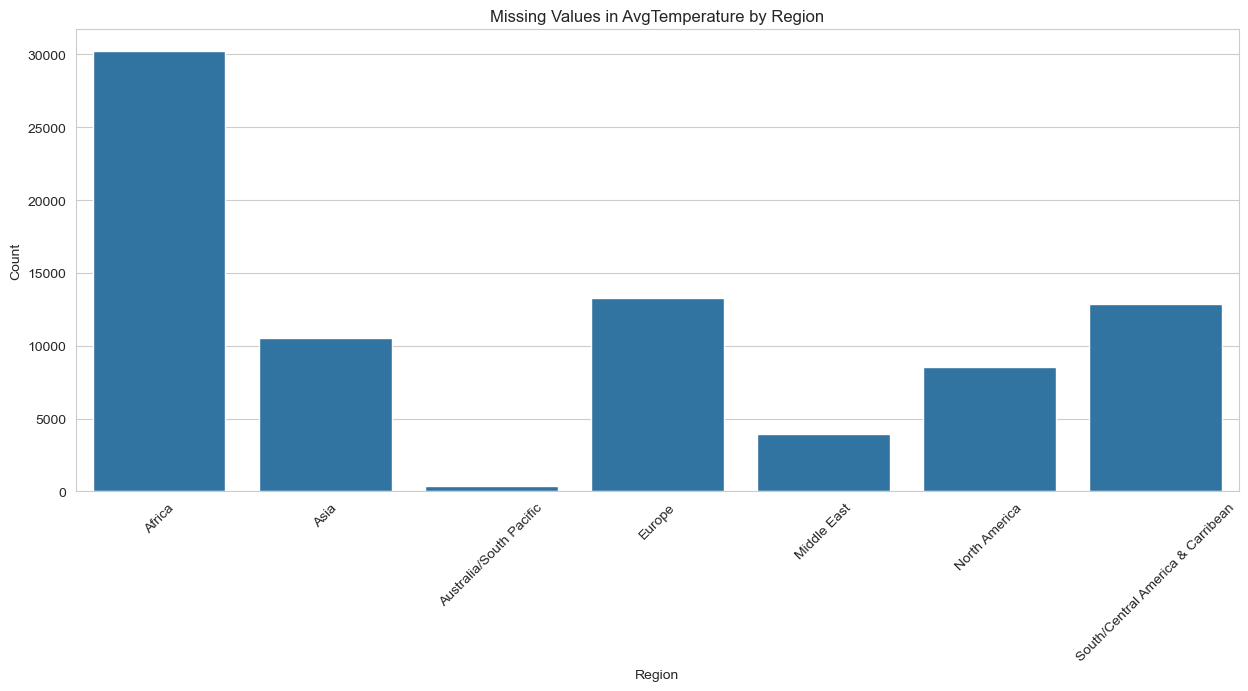

In [63]:
# Plot of the missing values in each region, along with the total number of values in each region
plt.figure(figsize=(15, 6))
sns.countplot(x="Region", data=missing_temp_values)
plt.title("Missing Values in AvgTemperature by Region")
plt.xlabel("Region")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

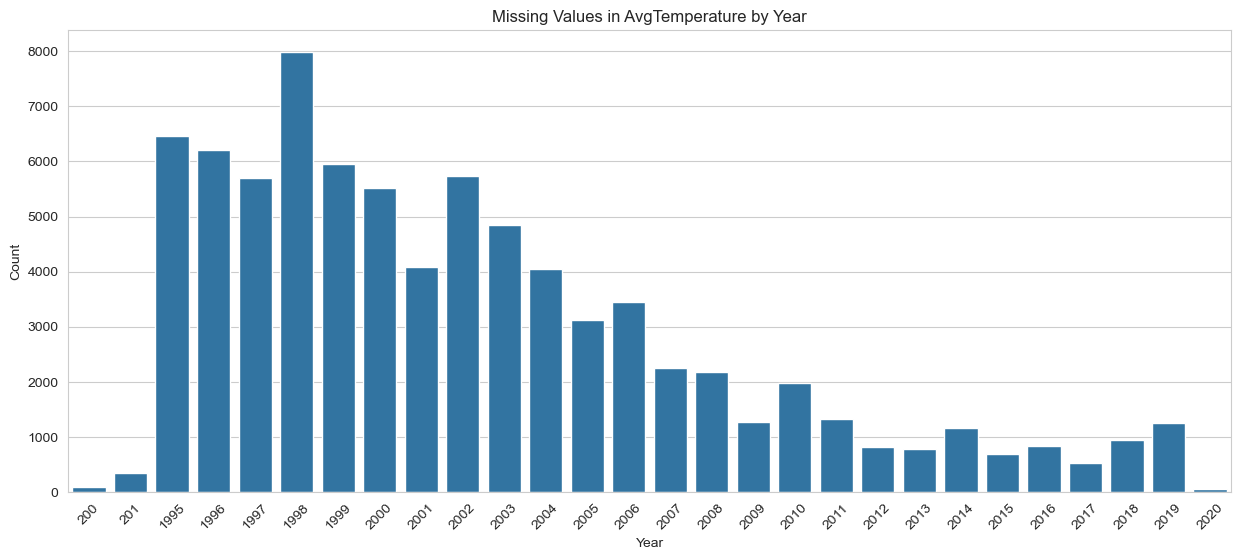

In [64]:
# Plot of the missing values by year
plt.figure(figsize=(15, 6))
sns.countplot(x="Year", data=missing_temp_values)
plt.title("Missing Values in AvgTemperature by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [65]:
# Missing values as a proportion of all values
missing_values_proportion = len(missing_temp_values) / len(df)
print(f"Proportion of missing values in AvgTemperature: {missing_values_proportion:.2%}")

Proportion of missing values in AvgTemperature: 2.74%


In [66]:
# By region
print("Percentage of missing values by region:")
missing_values_by_region = missing_temp_values.groupby("Region").size()
missing_values_by_region_proportion = missing_values_by_region / df.groupby("Region").size()
missing_values_by_region_proportion = missing_values_by_region_proportion.sort_values(ascending=False)
missing_values_by_region_proportion = missing_values_by_region_proportion.apply(lambda x: f"{x:.2%}")
missing_values_by_region_proportion.name = "Percentage of Missing Values"
missing_values_by_region_proportion

Percentage of missing values by region:


Region
Africa                               12.03%
South/Central America & Carribean     5.85%
Europe                                3.48%
Asia                                  3.32%
Middle East                           3.16%
Australia/South Pacific               0.70%
North America                         0.55%
Name: Percentage of Missing Values, dtype: object

In [67]:
# By year
print("Proportion of missing values by year:")
missing_values_by_year = missing_temp_values.groupby("Year").size()
missing_values_by_year_proportion = missing_values_by_year / df.groupby("Year").size()
missing_values_by_year_proportion = missing_values_by_year_proportion.sort_values(ascending=False)
missing_values_by_year_proportion = missing_values_by_year_proportion.apply(lambda x: f"{x:.2%}")
missing_values_by_year_proportion.name = "Proportion of Missing Values"
missing_values_by_year_proportion

Proportion of missing values by year:


Year
200     100.00%
201     100.00%
1998      6.70%
1995      5.45%
1996      5.23%
1999      4.98%
2002      4.81%
1997      4.81%
2000      4.61%
2003      4.08%
2001      3.42%
2004      3.41%
2006      2.93%
2005      2.65%
2007      1.95%
2008      1.90%
2010      1.72%
2019      1.18%
2011      1.17%
2009      1.11%
2014      1.06%
2018      0.89%
2016      0.78%
2012      0.74%
2013      0.71%
2015      0.64%
2017      0.49%
2020      0.18%
Name: Proportion of Missing Values, dtype: object

The main source of missing values is the Africa region, which has approximately 12% of its values missing.
Additionally, we can observe that as time passed, the number of missing values decreased.
This is likely due to improvements in data collection methods over time, as well as the proliferation of technology across the globe.

To fill in the missing values, we will apply time series forcasting.
For the missing year values, we will simply delete them since they are missing 100% of the data anyway.

In [68]:
# Delete the invalid years
df = df[df["Year"] >= 1900]

### Datetime conversion

Now that the invalid years have been removed from the data, we can a separate `Date` column to simplify date handling.
In the original dataset, the date is split into three separate columns, one for month, day, and year each. For simplicity in date processing and feature engineering, we will combine these three columns into a single datetime column.

In [69]:
df['Month'] = df['Month'].clip(lower=1, upper=12)
df['Day'] = df['Day'].clip(lower=1, upper=31)

df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Keep the Year column to simply future code
df.drop(columns=["Month", "Day"], inplace=True)

df.head()

,Region,Country,State,City,Year,AvgTemperature,Date
0,Africa,Algeria,NaN,Algiers,1995,64.2,1995-01-01
1,Africa,Algeria,NaN,Algiers,1995,49.4,1995-01-02
2,Africa,Algeria,NaN,Algiers,1995,48.8,1995-01-03
3,Africa,Algeria,NaN,Algiers,1995,46.4,1995-01-04
4,Africa,Algeria,NaN,Algiers,1995,47.9,1995-01-05


### Data imputation

In [70]:
from tqdm.notebook import tqdm


def simple_time_series_imputation(df, target_column='AvgTemperature', missing_value_indicator=-99):
    """
    Fill missing values using simple time series methods
    """

    # Create a copy of the dataframe
    df_copy = df.copy()

    # Replace missing value indicator with NaN if specified
    if missing_value_indicator is not None:
        df_copy[target_column] = df_copy[target_column].replace(missing_value_indicator, np.nan)

    # Count missing values before imputation
    missing_before = df_copy[target_column].isna().sum()

    if missing_before == 0:
        print("No missing values to impute.")
        return df_copy

    print(f"Missing values before imputation: {missing_before}")

    # Ensure date column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df_copy["Date"]):
        df_copy["Date"] = pd.to_datetime(df_copy["Date"])

    print(f"Processing each city separately")
    locations = df_copy["City"].unique()

    # Process each location
    imputed_dfs = []
    for location in tqdm(locations, desc=f"Processing Cities"):
        # Get data for this location
        location_data = df_copy[df_copy["City"] == location].copy()

        # Skip if no missing values
        if not location_data[target_column].isna().any():
            imputed_dfs.append(location_data)
            continue

        # Sort by date
        location_data = location_data.sort_values(by="Date")

        # Apply simple imputation methods
        # 1. Linear interpolation (for small gaps)
        location_data[target_column] = location_data[target_column].interpolate(method='linear')

        # 2. Forward fill then backward fill (for any remaining gaps)
        location_data[target_column] = location_data[target_column].ffill().bfill()

        imputed_dfs.append(location_data)

        # Combine all locations
        df_imputed = pd.concat(imputed_dfs)

    # Count missing values after imputation
    missing_after = df_imputed[target_column].isna().sum()
    print(f"Missing values after imputation: {missing_after}")
    print(f"Values filled: {missing_before - missing_after}")

    # If missing_value_indicator was provided, replace NaN back to the indicator for any remaining missing values
    if missing_value_indicator is not None and missing_after > 0:
        df_imputed[target_column] = df_imputed[target_column].fillna(missing_value_indicator)

    return df_imputed

In [71]:
# Apply the seasonal mean imputation function to the dataframe
df = simple_time_series_imputation(df, target_column='AvgTemperature', missing_value_indicator=-99)

Missing values before imputation: 79232
Processing each city separately


Processing Cities:   0%|          | 0/321 [00:00<?, ?it/s]

Missing values after imputation: 0
Values filled: 79232


In [72]:
missing_values = df[df["AvgTemperature"] == -99]

# Check if there are any missing values left
if len(missing_values) == 0:
    print("No missing values left in AvgTemperature column.")
else:
    print(f"Missing values left in AvgTemperature column: {len(missing_values)}")

No missing values left in AvgTemperature column.


### Unit conversion

In the dataset, the temperature is in Fahrenheit, but we will convert it to Celsius for better interpretability. This is because Canada uses the metric system and Celsius is the standard unit of temperature in Canada.

In [73]:
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5.0/9.0

# Convert the temperature to Celsius
df["AvgTemperature"] = fahrenheit_to_celsius(df["AvgTemperature"])

df.head()

,Region,Country,State,City,Year,AvgTemperature,Date
0,Africa,Algeria,NaN,Algiers,1995,17.888889,1995-01-01
1,Africa,Algeria,NaN,Algiers,1995,9.666667,1995-01-02
2,Africa,Algeria,NaN,Algiers,1995,9.333333,1995-01-03
3,Africa,Algeria,NaN,Algiers,1995,8.000000,1995-01-04
4,Africa,Algeria,NaN,Algiers,1995,8.833333,1995-01-05


### Outlier detection and treatment

In [74]:
# TODO

### Normalization/standardization of features

In order to improve the performance of the model, we will normalize the temperature to the range [-1, 1].

In [75]:
# Normalize the temperature
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
df["AvgTemperature"] = scaler.fit_transform(df[["AvgTemperature"]])
df.head()

,Region,Country,State,City,Year,AvgTemperature,Date
0,Africa,Algeria,NaN,Algiers,1995,0.42750,1995-01-01
1,Africa,Algeria,NaN,Algiers,1995,0.24250,1995-01-02
2,Africa,Algeria,NaN,Algiers,1995,0.23500,1995-01-03
3,Africa,Algeria,NaN,Algiers,1995,0.20500,1995-01-04
4,Africa,Algeria,NaN,Algiers,1995,0.22375,1995-01-05


# Feature Engineering